# Random Forest Classifier

In [7]:
# IMPORT

# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import cross_val_score

# Plotting and tree visualization
import matplotlib.pyplot as plt
from sklearn.tree import export_graphviz
import graphviz

## Data loading and preprocessing

Load the dataset and split it into training and test sets. The features 'X' are the number of hits, QCD/hits, shower width (both in x and y direction) for each station (20 columns). The target variable 'y' is the Starting station.

In [8]:
# Load
df = pd.read_csv('data.csv')

# Preprocess
X = df.drop(columns=['Starting station'])
y = df['Starting station']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Hyperparameter tuning

Use RandomizedSearchCV to search parameters within a range per hyperparameters. The goal is to find the best hyperparameters for our model. RandomizedSearchCV trains different models and saves them as variables. <br>

Hyperparameters to tune:
1. n_estimators: number of decision trees in the forest. A high value improves the performance of the model but increases the computational cost of training and predicting.
2. max_depth: maximum depth of each decision tree in the forest. A high value can lead to overfitting; a low value can lead to underfitting. <br>

RandomizedSearchCV trains many models and save them as variables. Using cross validation, it splits the data into equal-sized groups and using them to train or test the results. At the end, it averages the accuracy score of each group and finds the best model.

In [9]:
# Define the hyperparameters and their ranges in a dictionary
param_dist = {'n_estimators': randint(50,500), 'max_depth': randint(1,20)}

# Create a Random Forest Classifier
rf = RandomForestClassifier()

# Find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5)

# Fit the random search to the data (the output already shows the hyperparameters of the best estimator)
rand_search.fit(X_train, y_train)


,estimator,RandomForestClassifier()
,param_distributions,"{'max_depth': <scipy.stats....x73c138342c80>, 'n_estimators': <scipy.stats....x73c1382a17b0>}"
,n_iter,5
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


Create a variable for the best model and print its hyperparameters.

In [10]:
best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 19, 'n_estimators': 61}


Fit the best model found by the RandomizedSearchCV to the data.

In [11]:
best_rf.fit(X_train, y_train)

,n_estimators,61
,criterion,'gini'
,max_depth,19
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## Evaluate the model 
Check the accuracy of the predictions.

In [12]:
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy)


Accuracy:  0.8876404494382022


## Visualize the results

Use graphviz to visualize the trees. This package uses the format "DOT" as a graph description language. For example, here we visualize the first few nodes of the first tree. Each node contains three informations:
1. The variable name and the condition used to split the data.
2. The % of samples in each split.
3. The % of samples per class (Starting station) in each split. <br>

The color of each node represents the majority class predicted by that node. Saturated colors mean that the node is purer, whereas faded colors mean that the node is mixed.

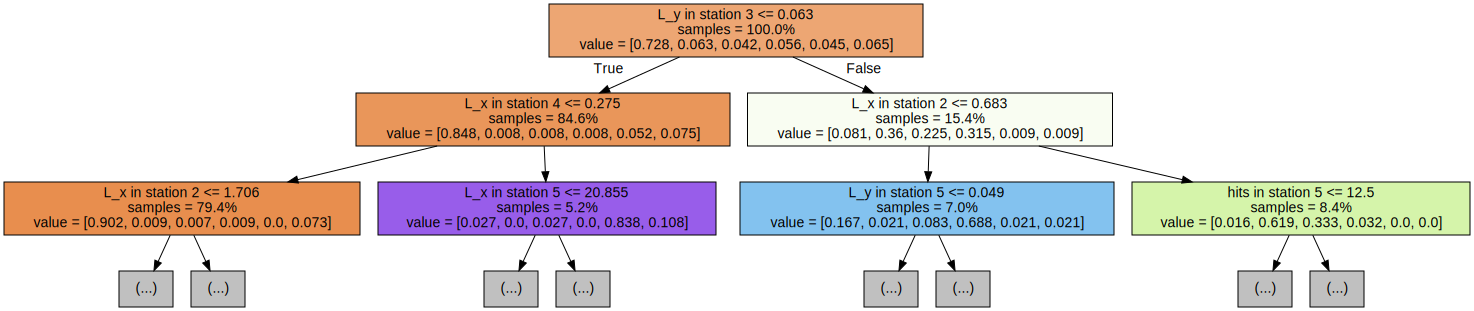

In [13]:
tree = best_rf.estimators_[0]
dot_data = export_graphviz(tree, feature_names=X_train.columns, filled=True, max_depth=2, impurity=False, proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

## Confusion Matrix

Plot the Confusion Matrix to compare the true (rows) and predicted (columns) classes. 

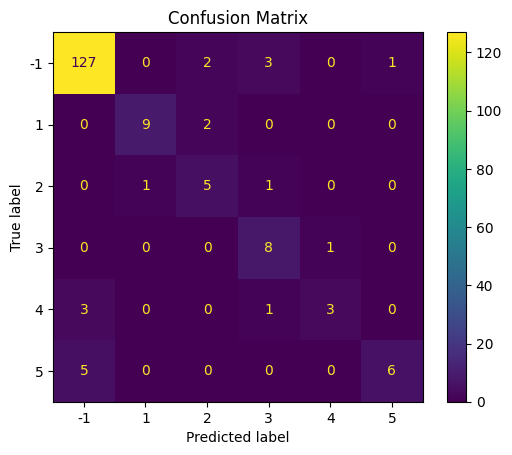

In [14]:
cm = confusion_matrix(y_test, y_pred)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_rf.classes_)
display.plot()
plt.title("Confusion Matrix")
plt.show()


## Feature importance

Plot the Feature Importance to quantify the usefulness of each feature in the model. A higher score means that the feature contributes more to the accuracy of the classification. Note that the importance score on the y axis is relative, not percentage.

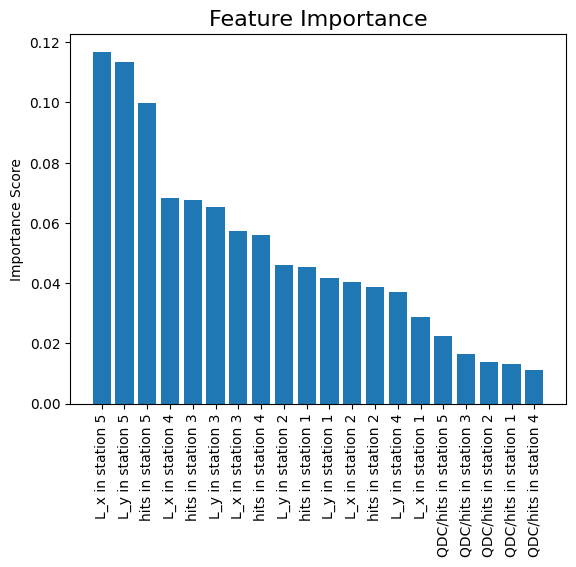

In [15]:
feature_importances = best_rf.feature_importances_
feature_names = X.columns
indices = np.argsort(feature_importances)[::-1]

plt.figure()
plt.title("Feature Importance", fontsize=16)
plt.bar(range(len(feature_importances)), feature_importances[indices], align="center")
plt.xticks(range(len(feature_importances)), feature_names[indices], rotation=90)
plt.ylabel("Importance Score")
plt.show()